In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import SVG
from IPython.display import display

In [2]:
#Берем файл со всеми дескрипторами (Из той папки, где код)
data = pd.read_excel('C://Users//plato//Documents//Python Scripts//CH3CN_final//CH3CN_ALL.xlsx', index_col=0) 

In [3]:
merged_df = data[['F01[C-N]', 'B05[O-O]', 'F06[N-B]:(Dragon7)', 'LDI', 'LLS_02:(Dragon7)', 'E LUMO (eV)', 'F04[C-B]', 'LnLn']]

In [4]:
#Сохраняем в отдельный файл (он сохранится в ту папку, в которой этот код)
merged_df.to_excel(f'CH3CN_SVR.xlsx', index=True)

In [5]:
#Загружаем наш сохраненный файл
Porphs_data = pd.read_excel('C://Users//plato//Documents//Python Scripts//CH3CN_final//CH3CN_SVR.xlsx', index_col=0) 
Porphs_data.head()

,F01[C-N],B05[O-O],F06[N-B]:(Dragon7),LDI,LLS_02:(Dragon7),E LUMO (eV),F04[C-B],LnLn
SR No,,,,,,,,
2,4,0,0,0.2224,1.0,-1.68,2,0.078814
3,4,0,0,0.1860,1.0,-1.58,3,0.160491
4,5,0,1,0.1898,1.0,-1.74,3,1.468449
5,5,0,0,0.1897,1.0,-1.87,3,0.730410
6,5,0,0,0.1904,1.0,-1.90,3,0.770710


In [6]:
# Create correlation matrix
corr_matrix = Porphs_data.corr().abs()
corr_matrix
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features 
BDP_data1 = Porphs_data.drop(Porphs_data[to_drop], axis=1)

In [7]:
#разделяем на целевую переменную и дескрипторы
y = BDP_data1.LnLn
X = BDP_data1.drop(['LnLn'], axis=1)

from sklearn import preprocessing
# normalize the data attributes
X = pd.DataFrame(preprocessing.scale(X), columns=X.columns, index=X.index)

#делаем тренировочную выборку
X_train = X.drop([5, 8, 13, 20, 48, 25, 16, 74], axis=0)
#делаем тренировочную целевую переменную
y_train = y.drop([5, 8, 13, 20, 48, 25, 16, 74], axis=0)
#делаем тестовую выборку
X_test = X.loc[[5, 8, 13, 20, 48, 25, 16, 74]]
#делаем тестовую целевую переменную
y_test = y.loc[[5, 8, 13, 20, 48, 25, 16, 74]]

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.svm import SVR
clf_svr = SVR(C=1.0, gamma='scale', epsilon=0.1)
parameters = {'kernel':['linear'], 
              'gamma':['scale', 'auto'],
              'C':[100000], 
              "epsilon":[0.001]}
grid_search_cv_clf = GridSearchCV(clf_svr, parameters, cv=5, n_jobs=-1)
grid_search_cv_clf.fit(X_train, y_train)
y_train_pred = grid_search_cv_clf.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
y_test_pred = grid_search_cv_clf.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
# Выводим текущие значения коэффициентов детерминации
print("Train R^2:", train_r2)
print("Test R^2:", test_r2)

Train R^2: 0.7323565308662647
Test R^2: 0.8801735700691318


In [9]:
R2_adj = 1 - ( 1-train_r2 ) * ( len(y_train) - 1 ) / ( len(y_train) - X_train.shape[1] - 1 )
print("R^2 adjusted:", R2_adj)

R^2 adjusted: 0.6508998228690409


In [10]:
# наилучшие параметры SVR
grid_search_cv_clf.best_params_

{'C': 100000, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'linear'}

In [11]:
#новый SVR с наилучшими параметрами
best_clf = grid_search_cv_clf.best_estimator_

In [12]:
#Максимальная ошибка предсказания
import sklearn.metrics as metrics
MaxAE = metrics.max_error(y_train, y_train_pred)  #max_error metric calculates the maximum residual error
print(f"MaxAE: {MaxAE}")
#Средняя абсолютная ошибка предсказания
MAE = metrics.mean_absolute_error(y_train, y_train_pred) #Mean absolute error regression loss
print(f"MAE: {MAE}")

MaxAE: 1.83266269196324
MAE: 0.30214067254577454


In [13]:
import sklearn.metrics as metrics
metrics.mean_squared_error(y_train, y_train_pred) #Mean squared error regression loss
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
print(f"RMSE_train: {rmse_train}")
rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE_test: {rmse_test}")

RMSE_train: 0.4847937249983537
RMSE_test: 0.28884535793891347


In [14]:
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [15]:
mape_train = calculate_mape(y_train, y_train_pred)
mape_test = calculate_mape(y_test, y_test_pred)
print(f"MAPE for the training dataset: {mape_train}")
print(f"MAPE for the test dataset: {mape_test}")

MAPE for the training dataset: 73.89570474056954
MAPE for the test dataset: 29.70564307496062


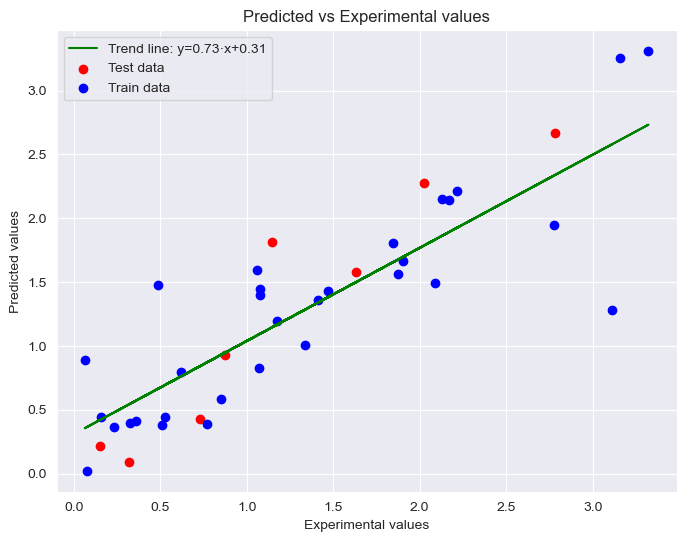

intercept: 0.3085995192368002
slope: 0.7300280594345745


In [16]:
import matplotlib.pyplot as plt

# Строим график
plt.figure(figsize=(8, 6))
# Выполнение линейной аппроксимации
slope, intercept = np.polyfit(y_train, y_train_pred, 1)
plt.plot(y_train, slope * y_train + intercept, color='green', label='Trend line: y=0.73·x+0.31')
plt.scatter(y_test, y_test_pred, color='red', label='Test data')
plt.scatter(y_train, y_train_pred, color='blue', label='Train data')
plt.title('Predicted vs Experimental values')
plt.xlabel('Experimental values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)
plt.show()

print(f"intercept: {intercept}")
print(f"slope: {slope}")

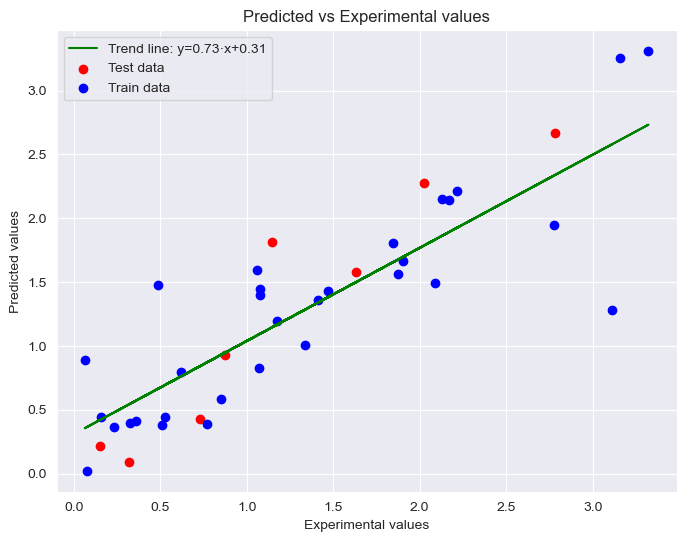

In [17]:
#Сохраняет в PDF в высоком качестве
import matplotlib.pyplot as plt

# Строим график
plt.figure(figsize=(8, 6))
# Выполнение линейной аппроксимации
slope, intercept = np.polyfit(y_train, y_train_pred, 1)
plt.plot(y_train, slope * y_train + intercept, color='green', label='Trend line: y=0.73·x+0.31')
plt.scatter(y_test, y_test_pred, color='red', label='Test data')
plt.scatter(y_train, y_train_pred, color='blue', label='Train data')
plt.title('Predicted vs Experimental values')
plt.xlabel('Experimental values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)

# Сохранение графика в PDF
plt.savefig('CH3CN_SVR_graph.pdf')

# Отображение графика (необязательно)
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler
# Получите стандартизированные коэффициенты регрессии
scaler = StandardScaler()
best_clf.fit(X_train, y_train)
standardized_coefficients = best_clf.coef_

In [19]:
# Определите относительный вклад каждого дескриптора
relative_contributions = np.abs(standardized_coefficients)

In [20]:
# Нормализуйте относительный вклад в процентах
total_contribution = np.sum(relative_contributions)
relative_contributions_percent = (relative_contributions / total_contribution) * 100

In [21]:
# Выводим относительный вклад в процентах
relative_contributions_percent

array([[18.75325465, 15.49346742, 20.69905033, 16.08690542,  8.59028061,
         8.67077341, 11.70626816]])

In [22]:
total_contribution

2.8395678581709944

In [23]:
#Считаем q2
#import pandas as pd
#import numpy as np
#from sklearn.svm import SVR

# Предполагается, что X_train и y_train уже определены и предобработаны

# Создаем пустой датафрейм для предсказаний
#y_predict = pd.DataFrame(columns=['Predicted'])

# Цикл для исключения одного элемента и обучения модели
#for index_to_exclude in X_train.index:
    # Создаем новую выборку, исключая текущий элемент
 #   X_train_subset = X_train.drop([index_to_exclude], axis=0)
  #  y_train_subset = y_train.drop([index_to_exclude], axis=0)
   # X_solo = X_train.loc[[index_to_exclude]]
    
    # Обучаем модель SVR с линейным ядром
#    model = SVR(kernel='linear', C=100000, epsilon=0.001)
#    model.fit(X_train_subset, y_train_subset)
#    
    # Предсказываем значение для исключенного элемента
#    y_pred = model.predict(X_solo)
    
    # Добавляем предсказание в датафрейм
#    y_predict.loc[index_to_exclude] = y_pred

#from sklearn.metrics import r2_score as r2
#q2 = r2(y_train,y_predict)
#print('q2 =', q2)

In [24]:
feature_names = BDP_data1.columns.values[:-1]

In [25]:
feature_names 

array(['F01[C-N]', 'B05[O-O]', 'F06[N-B]:(Dragon7)', 'LDI',
       'LLS_02:(Dragon7)', 'E LUMO (eV)', 'F04[C-B]'], dtype=object)

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE, plot_ale

In [27]:
svr_ale = ALE(best_clf.predict, feature_names=feature_names, target_names=['LnLn'])

In [28]:
X_train1 = X_train.to_numpy()

In [29]:
svr_exp = svr_ale.explain(X_train1)

C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  w

In [48]:
axes = plot_ale(svr_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7});

# Сохранение графика в PDF
plt.savefig('CH3CN_SVR_ale_plot.pdf', format='pdf')

# Если необходимо закрыть окно с графиком после сохранения
plt.close()

In [49]:
import shap
shap.initjs()

In [50]:
model = best_clf

In [33]:
explainer = shap.Explainer(model, X_train)
shap_test = explainer(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

Shap values length: 8

Sample shap value:
.values =
array([-0.01154372, -0.06434102, -0.22107471, -0.18044009, -0.25686677,
       -0.20499516,  0.09064201])

.base_values =
1.2802264124918674

.data =
array([-0.08615569, -0.23249528, -0.29897404,  0.33279578,  1.00444614,
       -0.78611027, -0.21674839])


In [34]:
print(f"Sample shap value:\n{shap_test[0]}")
# Вывод ожидаемого (базового) значения
print(f"Expected value: {explainer.expected_value:.1f}")

# Вывод среднего значения целевой переменной в обучающем наборе
print(f"Average target value (training data): {y_train.mean():.1f}")

# Вывод базового значения SHAP
unique_base_values = np.unique(shap_test.base_values)
print(f"Base value: {unique_base_values[0]:.1f}")

Sample shap value:
.values =
array([-0.01154372, -0.06434102, -0.22107471, -0.18044009, -0.25686677,
       -0.20499516,  0.09064201])

.base_values =
1.2802264124918674

.data =
array([-0.08615569, -0.23249528, -0.29897404,  0.33279578,  1.00444614,
       -0.78611027, -0.21674839])
Expected value: 1.3
Average target value (training data): 1.3
Base value: 1.3


In [35]:
(shap_test.data == X_test).describe()

,F01[C-N],B05[O-O],F06[N-B]:(Dragon7),LDI,LLS_02:(Dragon7),E LUMO (eV),F04[C-B]
count,8,8,8,8,8,8,8
unique,1,1,1,1,1,1,1
top,True,True,True,True,True,True,True
freq,8,8,8,8,8,8,8


In [36]:
pd.DataFrame(shap_test.data, columns=shap_test.feature_names, 
             index=X_test.index)

,F01[C-N],B05[O-O],F06[N-B]:(Dragon7),LDI,LLS_02:(Dragon7),E LUMO (eV),F04[C-B]
SR No,,,,,,,
5,-0.086156,-0.232495,-0.298974,0.332796,1.004446,-0.786110,-0.216748
8,0.585859,-0.232495,-0.298974,0.657506,1.004446,0.380970,-0.216748
13,-0.758170,4.301163,-0.298974,0.997827,1.004446,1.278724,-0.216748
20,1.257873,-0.232495,-0.298974,0.467051,0.220978,-0.247458,-1.424347
48,1.257873,-0.232495,-0.298974,-0.700656,-1.476536,1.009398,-0.216748
25,-0.758170,-0.232495,-0.298974,1.319415,0.220978,-1.279875,-1.424347
16,1.257873,-0.232495,-0.298974,0.701217,1.004446,0.021868,-1.424347
74,-0.758170,-0.232495,-0.298974,-1.846508,-1.476536,-1.818527,3.406046


In [37]:
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df

,F01[C-N],B05[O-O],F06[N-B]:(Dragon7),LDI,LLS_02:(Dragon7),E LUMO (eV),F04[C-B]
SR No,,,,,,,
5,-0.011544,-0.064341,-0.221075,-0.180440,-0.256867,-0.204995,0.090642
8,0.346312,-0.064341,-0.221075,-0.328767,-0.256867,0.082355,0.090642
13,-0.369399,1.930231,-0.221075,-0.484225,-0.256867,0.303393,0.090642
20,0.704167,-0.064341,-0.221075,-0.241768,-0.065758,-0.072372,0.492057
48,0.704167,-0.064341,-0.221075,0.291639,0.348311,0.237081,0.090642
25,-0.369399,-0.064341,-0.221075,-0.631126,-0.065758,-0.326566,0.492057
16,0.704167,-0.064341,-0.221075,-0.348734,-0.256867,-0.006061,0.492057
74,-0.369399,-0.064341,-0.221075,0.815063,0.348311,-0.459189,-1.113602


In [38]:
# Получаем ожидаемое значение как скаляр (если это действительно нужно)
expected_value = explainer.expected_value

# Выполняем операции с предсказаниями, ожидаемым значением и суммой SHAP
predictions = model.predict(X_test)
shap_sum = shap_df.sum(axis=1)

# Проверяем близость между предсказаниями и целевым выражением
np.isclose(predictions, expected_value + shap_sum)

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [39]:
columns = shap_df.apply(np.abs).mean()\
                 .sort_values(ascending=False).index

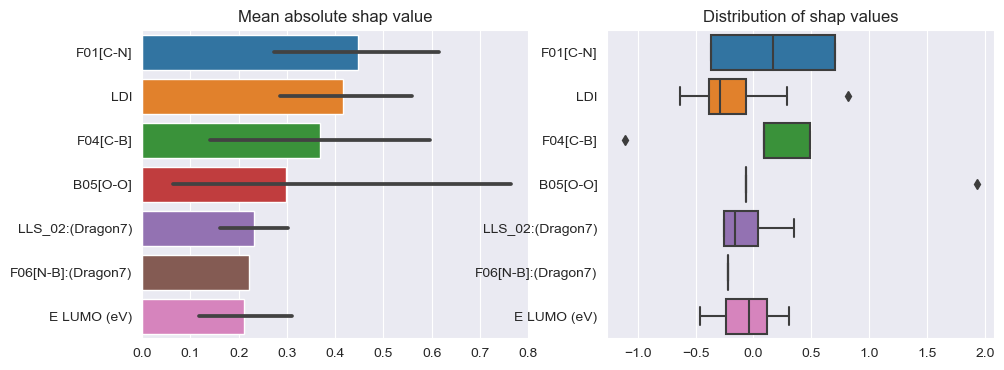

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(11,4))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
            ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

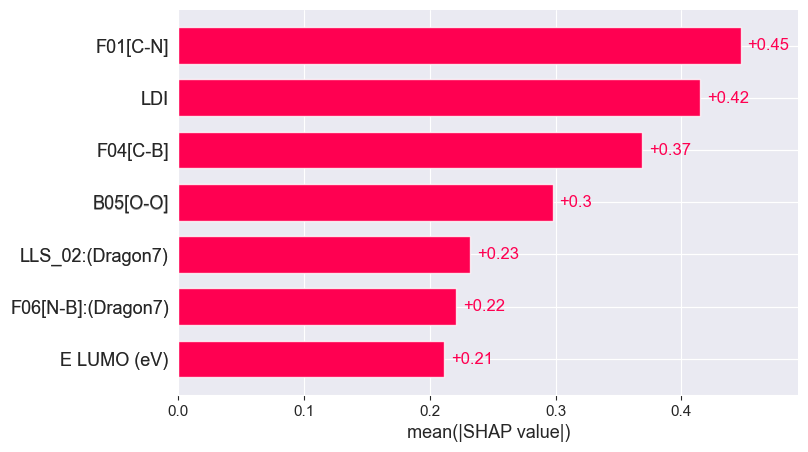

In [41]:
shap.plots.bar(shap_test)

In [52]:
import shap
import matplotlib.pyplot as plt

# Предположим, что у вас уже есть обученная модель, X_test и shap_values

# Создаем фигуру
plt.figure()

# Построение SHAP summary plot
shap.summary_plot(shap_test, X_test, show=False)  # Убедитесь, что show=False

# Сохранение графика в PDF
plt.savefig('CH3CN_SVR_SHAP_test_plot.pdf', format='pdf')

# Если необходимо закрыть окно с графиком после сохранения
plt.close()

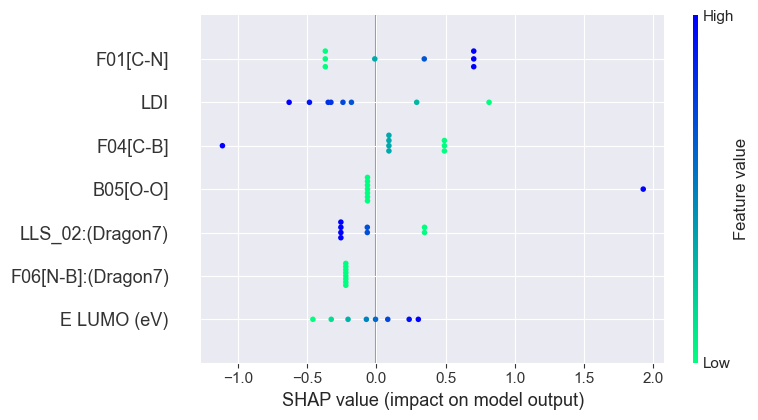

In [43]:
shap.summary_plot(shap_test, cmap=plt.get_cmap("winter_r"))

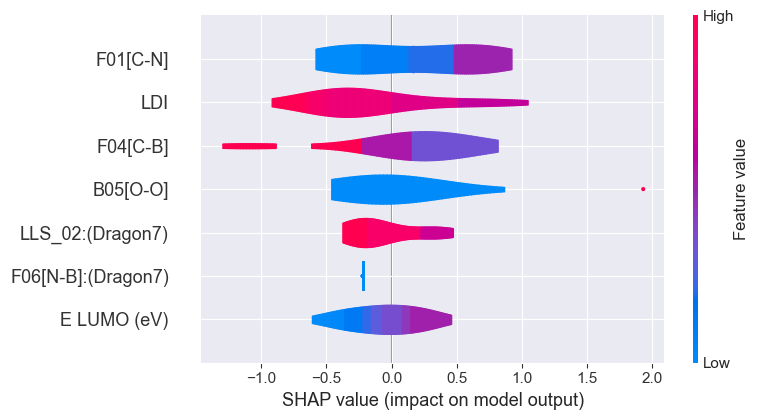

In [44]:
shap.summary_plot(shap_test, plot_type='violin')